In [ ]:
#!pip install langchain
!pip install --upgrade --quiet  langchain-openai langchain_community tiktoken chromadb langchain
!pip install --upgrade --quiet  youtube-transcript-api
!pip install --upgrade --quiet  langchain langchain-community langchain-openai langchain-experimental neo4j
!pip install pytube
!pip install langchain-chroma
!pip install streamlit-agraph

!pip install plotly



In [202]:
!pip install networkx

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
    --------------------------------------- 0.0/1.6 MB 660.6 kB/s eta 0:00:03
   - -------------------------------------- 0.1/1.6 MB 656.4 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.6 MB 1.6 MB/s eta 0:00:01
   ---------- ----------------------------- 0.4/1.6 MB 2.5 MB/s eta 0:00:01
   -------------------------- ------------- 1.1/1.6 MB 4.9 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 6.6 MB/s eta 0:00:00


In [2]:

import os

import networkx as nx
import numpy as np


from langchain.chains.summarize import load_summarize_chain
from langchain_openai import ChatOpenAI
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain_text_splitters import CharacterTextSplitter
from langchain_community.document_loaders import YoutubeLoader
from langchain_community.document_loaders.youtube import TranscriptFormat
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import PromptTemplate



from io import StringIO
import matplotlib.pyplot as plt

from dotenv import load_dotenv
# Load enviromental variables
load_dotenv() 

True

## 1. Loading the data (Yotube Transcripts)

We are going to use the langchain dataloader for fetching youtube transcripts. In the future if the transcript is not available we could replace this with some audio-to-text model or something along those lines

https://python.langchain.com/v0.2/docs/integrations/document_loaders/youtube_transcript/


In [76]:
# Load YouTube transcript
loader = YoutubeLoader.from_youtube_url(
    "https://www.youtube.com/watch?v=77Q4gZDyTwA",
    chunk_size_seconds=45,
    transcript_format=TranscriptFormat.CHUNKS,
    add_video_info=True,
)
transcript_documents = loader.load()

# Extract video metadata
video_title = transcript_documents[0].metadata['title']
video_url = transcript_documents[0].metadata['source']
video_author = transcript_documents[0].metadata['author']

In [78]:
transcript_documents[0]

Document(metadata={'source': 'https://www.youtube.com/watch?v=77Q4gZDyTwA&t=0s', 'title': 'Introduction to Molecular Spectroscopy: Lecture 1 Rotational Spectroscopy', 'description': 'Unknown', 'view_count': 998, 'thumbnail_url': 'https://i.ytimg.com/vi/77Q4gZDyTwA/hqdefault.jpg?sqp=-oaymwExCJADEOABSFryq4qpAyMIARUAAIhCGAHwAQH4Af4EgALoAooCDAgAEAEYQyBSKHIwDw==&rs=AOn4CLA9UpmiH6jVap-qRKDBWC7q9BcDlw', 'publish_date': '2022-09-29 00:00:00', 'length': 3514, 'author': 'Michael Seery', 'start_seconds': 0, 'start_timestamp': '00:00:00'}, page_content="foreign so this is the first lecture in spectroscopy formally so those of you who've watched the I guess 10 or 15 minute introduction lecture um we know that I'm talking to an empty room so I'm trying to recreate the lecture experience here as much as possible um but I hope you are all enjoying this course from wherever you're viewing it and really in this course I want to um talk about to get something like this here this is a structure um uh we s

###  1.1 Save Transcript to File

Youtube Loader by default gives the transcript in chunks. I am stiching back the documented together because I want to add the start_timestamp and end_timestamps explicitely in the page_content.

In [79]:
# Create a StringIO object to hold the transcript content in memory as a variable
memory_file = StringIO()

# Define the output file name
output_file = 'youtube_script.txt'
# Open the file in write mode

chunks = transcript_documents
with open(output_file, 'w') as file:
    # Iterate over each chunk in the list with an index to access the next chunk
    for i in range(len(chunks)):
        # Extract metadata and content from the current chunk
        title = chunks[i].metadata.get('title', 'Unknown Title')
        start_timestamp = chunks[i].metadata.get('start_timestamp', 'Unknown Timestamp')
        page_content = chunks[i].page_content

        # Determine the end timestamp
        if i + 1 < len(chunks):
            end_timestamp = chunks[i + 1].metadata.get('start_timestamp', 'Unknown Timestamp')
        else:
            end_timestamp = "End of Video"  # or some appropriate end marker

        title = chunks[i].metadata.get('title')
        # Prepare the content to write
        content = (
            f"Video Extract : {title}\n"
            f"[{start_timestamp}---->{end_timestamp}]:\n{page_content}\n"
            f"\n"
        )

        # Write the content to both the file and the StringIO object
        file.write(content)
        memory_file.write(content)

# Get the content from the StringIO object as a string
memory_content = memory_file.getvalue()

# Print confirmation message
print(f"Script written to {output_file}")

# You can use `memory_content` as needed, it's the full script content in memory
print(memory_content)


Script written to youtube_script.txt
Video Extract : Introduction to Molecular Spectroscopy: Lecture 1 Rotational Spectroscopy
[00:00:00---->00:00:45]:
foreign so this is the first lecture in spectroscopy formally so those of you who've watched the I guess 10 or 15 minute introduction lecture um we know that I'm talking to an empty room so I'm trying to recreate the lecture experience here as much as possible um but I hope you are all enjoying this course from wherever you're viewing it and really in this course I want to um talk about to get something like this here this is a structure um uh we see the Spectrum has lots of

Video Extract : Introduction to Molecular Spectroscopy: Lecture 1 Rotational Spectroscopy
[00:00:45---->00:01:30]:
Peaks on it this particularly this particular Spectrum all the Peaks are regularly spaced uh there's a kind of a shape in the Spectrum you're getting a sense of increase in an increase in transition intensity and decrease again and this course is about

## 3. Generating a General Summary of the Transcript


Before we dive into creating the Knowledge Graph (KG), it's often helpful to create a general summary of the transcript. This step is optional, but I find it particularly useful for organizing the KG, as it provides a high-level overview of the content. The summary will be passed alongside the segmented chunks of the transcript, making it easier to identify key concepts and their relationships.



### 3.1 Summarizing the Transcript with LangChain

To generate the summary, we'll use a RefineDocumentChain (through the load_summarize_chain function). This Method of summarization first map each document (or segment of the transcript) to a standalone summary using an `StuffDocumentChain`.
The refine documents chain then constructs a global response by looping over the input documents and iteratively updating its answer. For each document, it passes all non-document inputs, the current document, and the latest intermediate answer to an LLM chain to get a new answer.

Reference:
https://python.langchain.com/v0.1/docs/use_cases/summarization/


In [81]:
llm = ChatOpenAI(temperature=0.2, max_tokens=4096)

# Initialize the text splitter with parameters suitable for transcript segmentation.
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=4000,         # Maximum size of each chunk
    chunk_overlap=1000,      # Overlap between chunks for context continuity
    length_function=len,     # Length function based on character count
    is_separator_regex=False # No regex separator used
)

# Split the transcript into smaller chunks.

chunks = text_splitter.split_text(memory_content)  #memory_content represents the full transcript text that we are splitting.

# Create document objects from the chunks.
transcript_chunk_documents = text_splitter.create_documents(chunks)

# Add metadata such as video title, URL, and author to each chunk.
# This metadata will be useful when creating the Knowledge Graph later
for i, document in enumerate(transcript_chunk_documents):
    document.metadata.update({
        "video_title": transcript_documents[0].metadata['title'],   # Title of the video
        "video_url": transcript_documents[0].metadata['source'],    # URL of the video
        "video_author": transcript_documents[0].metadata['author']  # Author of the video
    })

### 3.2 Define Prompt Templates

In [ ]:

initial_chunk_prompt_template = """
Task: Here is a partial transcript of a youtube video with timestamps. Your task is to destile the information from  the raw transcript and write a concise well structure article that summarizes the
      new or intersting information. The timestamps where the information is being extracted should be added at the end. In case part or the whole of the video is a tutorial it is important to list the steps provided. 
      The reader might then go to the timestamps to check so include a chronological list or timeline summarizing the sequence of topics discussed in the video.
Part of Transcription:
{text}
PARTIAL ARTICLE:

[start_timestamp---->end_timestamp]"""



refine_chunk_template = """
We are working on processing the information from a long youtube transcript and destile it into one well structure cohesive text either a Medium Article or a scientific paper whatever fits best. The idea is that a reader with a technical backgroud
can easily read our composition and understand what new information/technology/insight is being presented in the video.

We are working by parts because the transcript it's a very big.
We have made a partial document up to a certain point of the transcript: {existing_answer}

Your job is to merge and maybe if appropiate summarize this partial articles together into a consice coherent document with an abstract, introduction, body paragraphs and conclusion

Requirements for the document:
Focus on what new knowledege is the video presenting. Explain what new or intersting, technologies,tool,algorithm,discovery, are being discussed and how do they work and why are they relevant

The document should have an abstract,introduction, and a paragraph for each key topic/tool/algorithm/etc.
The body paragraphs should  reference the timestamps of the transcript that support what they are saying as if they were citations.
The reader might then go to the timestamps to check so include a chronological list or timeline summarizing the sequence of topics discussed in the video

In case the video or part of the video is a tutorial list the steps provided.


Continue and refine the existing partial article with  more context below if appropiate in a way that is still coherent. Otherwise return the current partial article
------------
{text}
------------


PARTIALLY PROCESS DOCUMENT:"""

In [82]:
# Initialize prompt templates for the initial summary and refinement steps.
intial_prompt = PromptTemplate.from_template(initial_chunk_prompt_template)
refine_chunk_prompt = PromptTemplate.from_template(refine_chunk_template)

# Load the summarization chain using the "refine" method.
chain = load_summarize_chain(
    llm=llm,
    chain_type="refine",
    question_prompt=intial_prompt,
    refine_prompt=refine_chunk_prompt,
    return_intermediate_steps=False,
    input_key="input_documents",
    output_key="output_text",
)

# Generate the refined summary from the transcript chunks.
result = chain.invoke({"input_documents": transcript_chunk_documents}, return_only_outputs=False)


In [83]:
# Print the final summary output.
print(result['output_text'])

# Store the final summary in a variable for later use.
summary_content = result['output_text']


Abstract:
The video "Introduction to Molecular Spectroscopy: Lecture 1 Rotational Spectroscopy" delves into the realm of spectroscopy, focusing on rotational spectroscopy in chemistry. This document aims to condense and highlight the key points discussed in the video, showcasing new technologies, insights, and advancements in the field of molecular spectroscopy.

Introduction:
Spectroscopy plays a crucial role in various branches of chemistry, enabling the analysis of molecular structures and compounds. This document provides an overview of the fundamental concepts presented in the video lecture, highlighting the advancements in molecular spectroscopy.

Body Paragraphs:
1. Importance of Spectroscopy in Chemistry [00:03:00---->00:03:45]:
The video emphasizes the critical role of spectroscopy in organic, inorganic, physical, and analytical chemistry, showcasing its significance in studying reaction rates, molecular interactions, and astrochemistry.

2. Analysis of Molecular Structures Us

## 4. Creating Knowledge Graph

After generating a summary of the transcript, we proceed to create the Knowledge Graph (KG). 

To do this, we use the `LLMGraphTransformer` from the `langchain_experimental.graph_transformers` library. This tool handles several critical tasks:

- **Identifying Key Nodes and Relationships:** Extracts and structures important entities (nodes) and their connections (relationships) from the text.
- **Entity Disambiguation:** Resolves ambiguities between similar or identical entities to ensure accurate representation.

The `LLMGraphTransformer` automates these processes, leveraging the language model to build the Knowledge Graph effectively.


In [84]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from streamlit_agraph import Node, Edge


In [85]:
# Initialize the LLM and the LLMGraphTransformer for processing documents.
llm = ChatOpenAI(temperature=0.2, max_tokens=4096)
llm_transformer = LLMGraphTransformer(llm=llm)

# Combine the summary with the original transcript.
processed_document = result['output_text'] + '\n Transcript' + memory_content

# Split the combined text into chunks and create document objects.
chunks_processed = text_splitter.split_text(processed_document)
documents = text_splitter.create_documents(chunks_processed)

# Convert the documents into graph documents for knowledge graph generation.
graph_documents = llm_transformer.convert_to_graph_documents(documents)

# Print the nodes and relationships extracted from the first graph document.
print(f"Nodes: {graph_documents[0].nodes}")
print(f"Relationships: {graph_documents[0].relationships}")


Nodes: [Node(id='Molecular Spectroscopy', type='Concept'), Node(id='Chemistry', type='Concept'), Node(id='Rotational Spectroscopy', type='Concept'), Node(id='Spectroscopy', type='Concept'), Node(id='Molecular Structures', type='Concept'), Node(id='Energy Level Transitions', type='Concept'), Node(id='Transitions', type='Concept'), Node(id='Theory', type='Concept'), Node(id='Observation', type='Concept'), Node(id='Electronic Transitions', type='Concept'), Node(id='Vibrational Transitions', type='Concept'), Node(id='Rotational Transitions', type='Concept'), Node(id='Energy', type='Concept'), Node(id='Energy Units', type='Concept'), Node(id='Light', type='Concept'), Node(id='Matter', type='Concept'), Node(id='Dipole Moment', type='Concept'), Node(id='Waves', type='Concept'), Node(id='Isotopic Substitution', type='Concept'), Node(id='Quantized Energy Levels', type='Concept'), Node(id='Selection Rules', type='Concept')]
Relationships: [Relationship(source=Node(id='Molecular Spectroscopy', ty

In [86]:
# Combine the result text with memory content, adding a newline separator and the string 'Transcript'
processed_document = result['output_text'] + '/n Transcript' + memory_content

# Split the combined document into chunks using the text splitter
chunks_processed = text_splitter.split_text(processed_document)

# Create document objects from the chunks
documents = text_splitter.create_documents(chunks_processed)

# Transform the document objects into graph-based documents using the LLM transformer
graph_documents = llm_transformer.convert_to_graph_documents(documents)



In [87]:

for node in graph_documents[0].nodes:
    print(node)

        


id='Molecular Spectroscopy' type='Concept'
id='Chemistry' type='Concept'
id='Rotational Spectroscopy' type='Concept'
id='Video Lecture' type='Concept'
id='Technologies' type='Concept'
id='Insights' type='Concept'
id='Advancements' type='Concept'
id='Branches Of Chemistry' type='Concept'
id='Reaction Rates' type='Concept'
id='Molecular Interactions' type='Concept'
id='Astrochemistry' type='Concept'
id='Energy Level Transitions' type='Concept'
id='Molecular Structures' type='Concept'
id='Absorption Of Energy' type='Concept'
id='Emission Of Energy' type='Concept'
id='Diverse Applications' type='Concept'
id='Ground States' type='Concept'
id='Excited States' type='Concept'
id='Uv Spectroscopy' type='Concept'
id='Petroscopy' type='Concept'
id='Theory' type='Concept'
id='Observation' type='Concept'
id='Spectroscopic Analysis' type='Concept'
id='Transitions' type='Concept'
id='Occupied Orbitals' type='Concept'
id='Unoccupied Orbitals' type='Concept'
id='Electron Distribution' type='Concept'
id

In [88]:

for relationship in graph_documents[0].relationships:
    print(relationship)

source=Node(id='Molecular Spectroscopy', type='Concept') target=Node(id='Chemistry', type='Concept') type='RELEVANCE'
source=Node(id='Molecular Spectroscopy', type='Concept') target=Node(id='Rotational Spectroscopy', type='Concept') type='FOCUS'
source=Node(id='Video Lecture', type='Concept') target=Node(id='Molecular Spectroscopy', type='Concept') type='CONTENT'
source=Node(id='Video Lecture', type='Concept') target=Node(id='Technologies', type='Concept') type='CONTENT'
source=Node(id='Video Lecture', type='Concept') target=Node(id='Insights', type='Concept') type='CONTENT'
source=Node(id='Video Lecture', type='Concept') target=Node(id='Advancements', type='Concept') type='CONTENT'
source=Node(id='Chemistry', type='Concept') target=Node(id='Branches Of Chemistry', type='Concept') type='INVOLVEMENT'
source=Node(id='Branches Of Chemistry', type='Concept') target=Node(id='Reaction Rates', type='Concept') type='SIGNIFICANCE'
source=Node(id='Branches Of Chemistry', type='Concept') target=N

## 5. Visualize Knowledge Graphs

We will use both 2D and 3D visualizations to explore the knowledge graph. In each visualization, we will focus on the top-n nodes based on their number of connections to highlight the most significant elements of the graph.


In [ ]:
import seaborn as sns
import plotly.graph_objects as go
import networkx as nx

sns.set_style('darkgrid')


### 5.1 2D Visualization

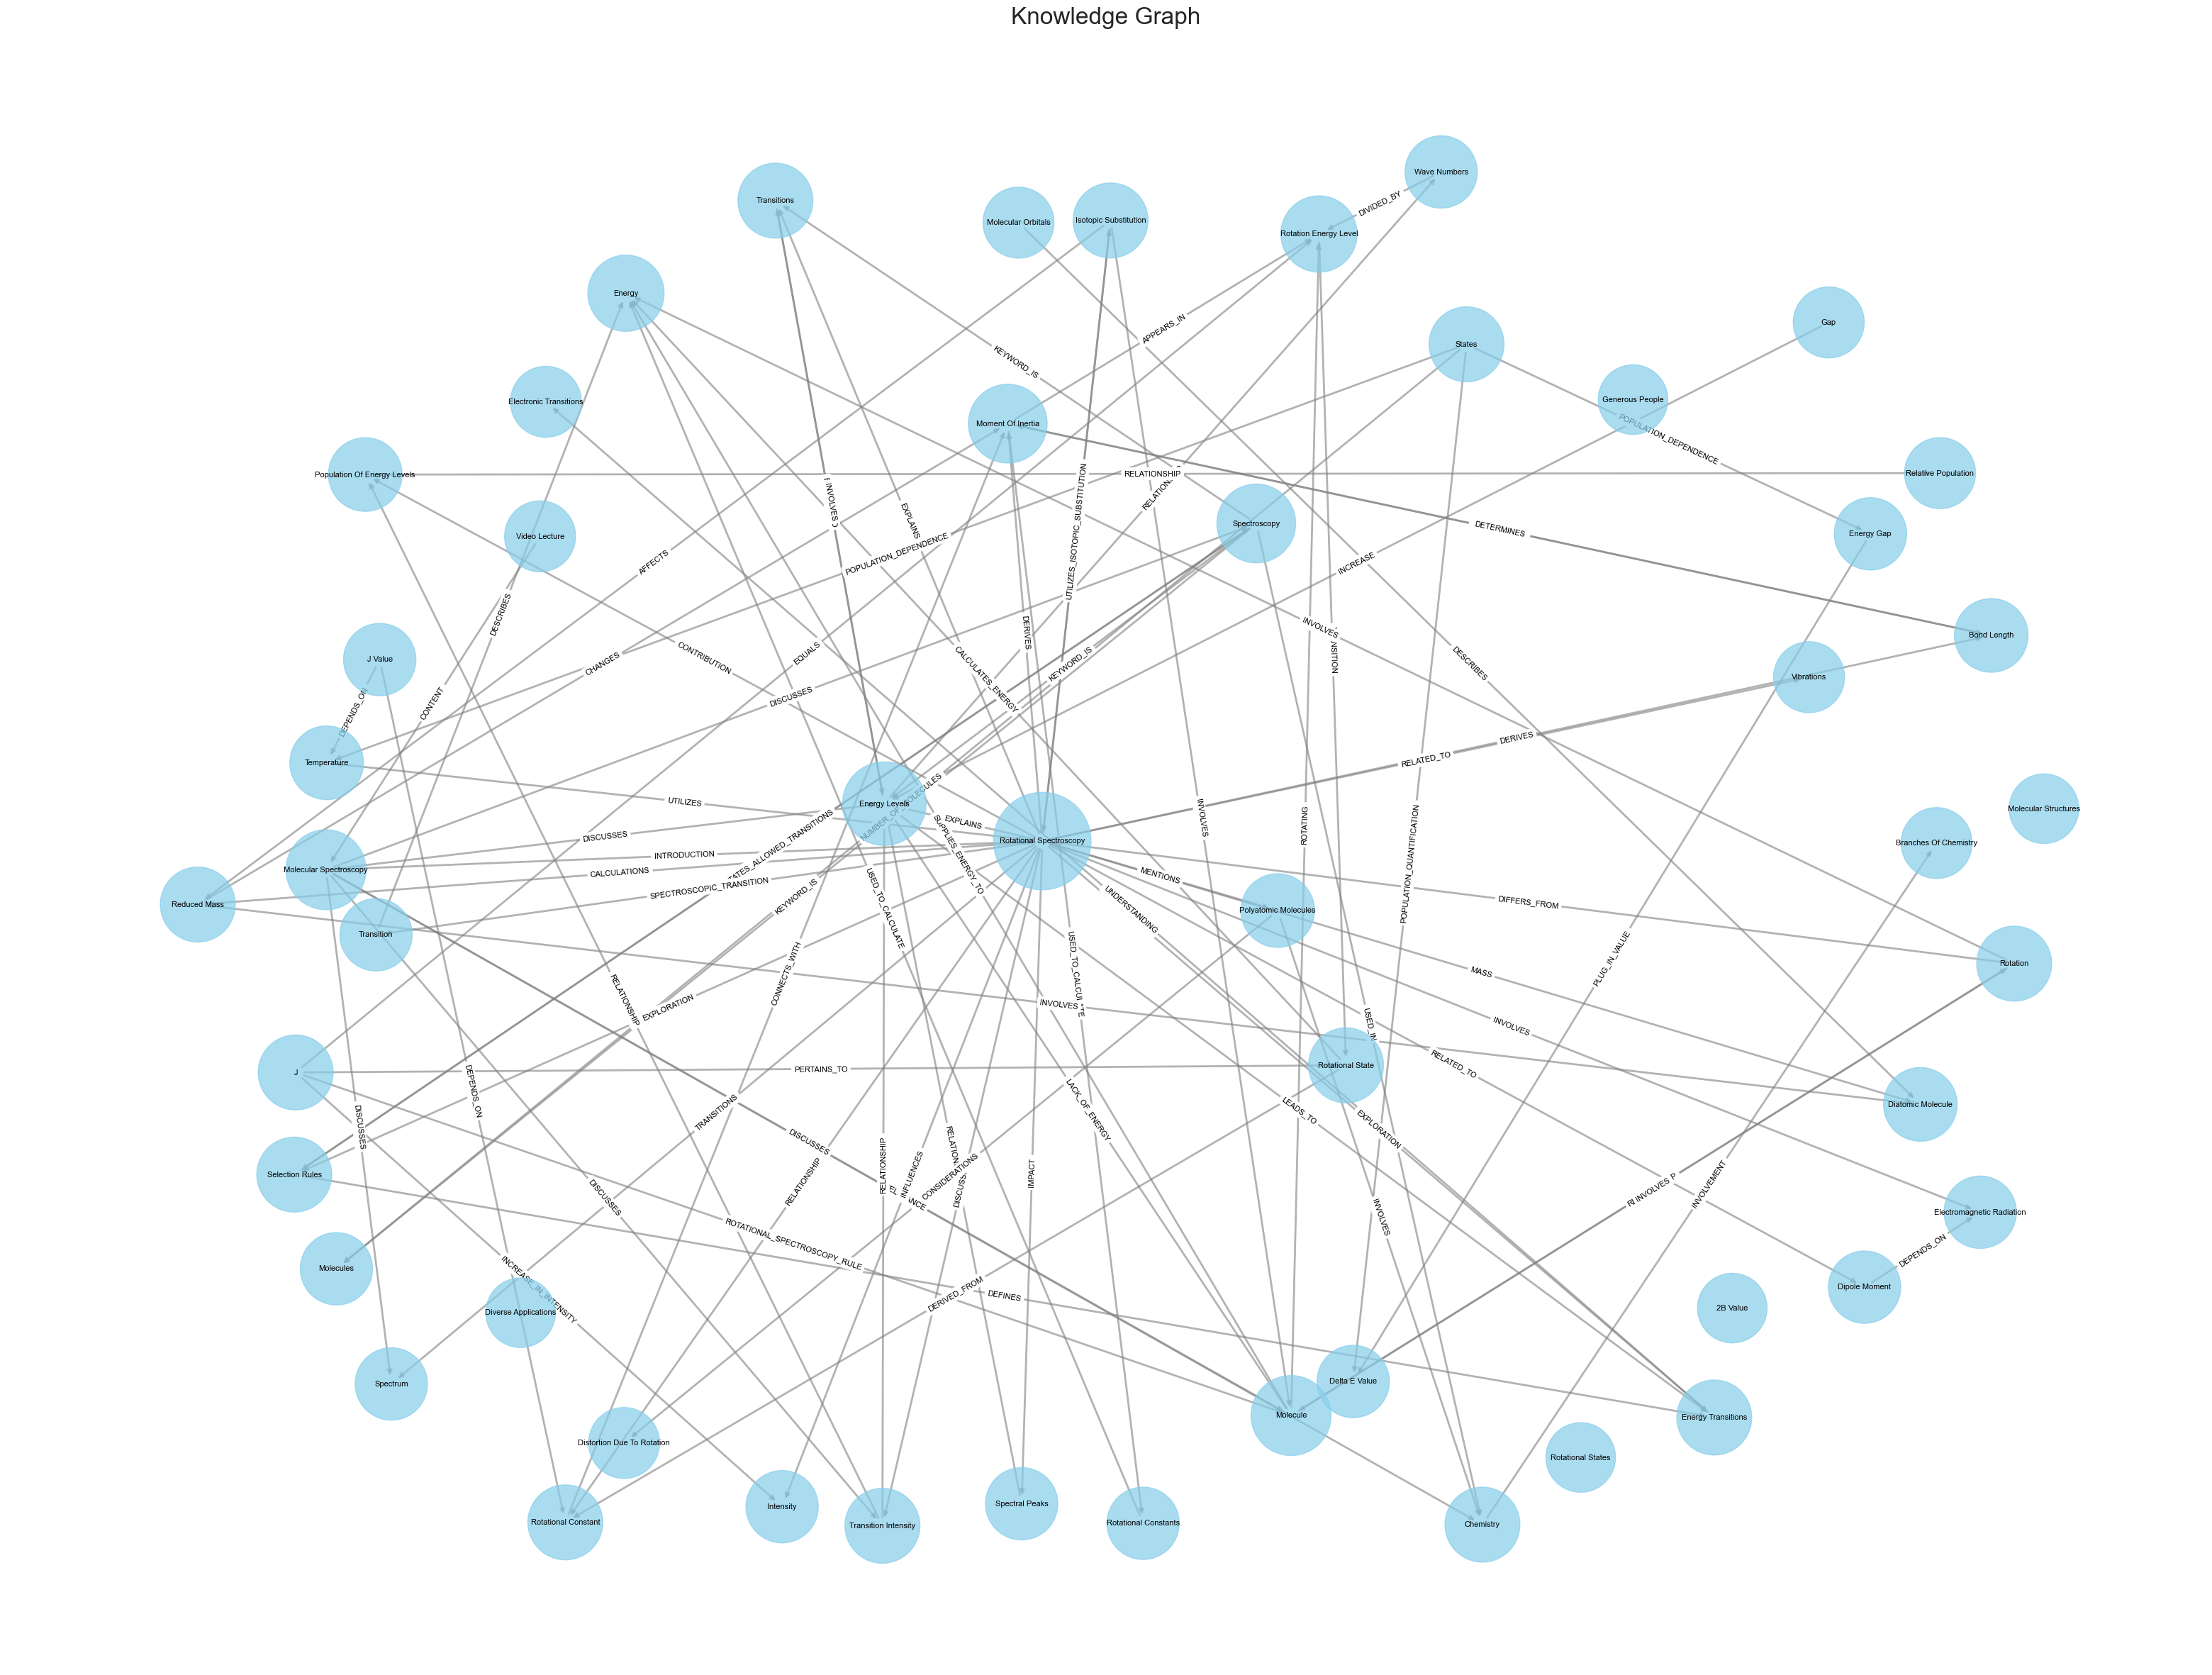

In [93]:
def create_networkx_graph(graph_documents):
    """
    Constructs a directed graph from a list of graph documents.
    
    Parameters:
    graph_documents (list): List of documents where each document contains nodes and relationships.

    Returns:
    nx.DiGraph: A directed graph with nodes and edges added from the documents.
    """
    G = nx.DiGraph()

    # Add nodes to the graph
    for doc in graph_documents:
        for node in doc.nodes:
            if node.id:  # Use only the id for labels
                G.add_node(str(node.id), label=node.id)

    # Add edges to the graph
    for doc in graph_documents:
        for relationship in doc.relationships:
            if relationship.source and relationship.target:  # Ensure relationships are valid
                G.add_edge(str(relationship.source.id), str(relationship.target.id), label=relationship.type)

    return G

def get_top_nodes_by_degree(G, top_n=25):
    """
    Gets the top N nodes by degree (sum of in-degree and out-degree).

    Parameters:
    G (nx.DiGraph): A directed graph.
    top_n (int): Number of top nodes to return.

    Returns:
    list: List of top N nodes by degree.
    """
    degree_dict = dict(G.degree(G.nodes))
    sorted_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)
    return sorted_nodes[:top_n]

def visualize_networkx_graph(G,top_n=50):
    """
    Visualizes a directed graph using Matplotlib.
    
    Parameters:
    G (nx.DiGraph): A directed graph to be visualized.
    """
    top_nodes = get_top_nodes_by_degree(G,top_n=top_n)
    subgraph = G.subgraph(top_nodes).copy()

    plt.figure(figsize=(40, 30))  # Increase figure size for better visibility

    # Compute positions for the nodes using the spring layout
    pos = nx.spring_layout(subgraph, k=1, iterations=25)  # Adjust k value for more natural spacing

    # Define node sizes based on their degree
    node_sizes = [5000 + 200 * subgraph.degree(node) for node in subgraph.nodes]
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.7)

    # Create a dictionary of node labels
    node_labels = {node: subgraph.nodes[node].get('label', node) for node in subgraph.nodes}
    nx.draw_networkx_labels(subgraph, pos, labels=node_labels, font_size=8, font_family='sans-serif', font_color='black')

    # Draw edges with specific width and color
    nx.draw_networkx_edges(subgraph, pos, edgelist=subgraph.edges(), width=2, edge_color='gray', alpha=0.6)

    # Create a dictionary of edge labels
    edge_labels = nx.get_edge_attributes(subgraph, 'label')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8, font_family='sans-serif')

    plt.title("Knowledge Graph", fontsize=24)
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
G = create_networkx_graph(graph_documents)
visualize_networkx_graph(G)


### 5.2 3D Visualization

In [91]:
def visualize_networkx_graph_3d(G,num_nodes=100):
    """
    Visualizes a directed graph in 3D using Plotly.
    
    Parameters:
    G (nx.DiGraph): A directed graph to be visualized.
    """
    top_nodes = get_top_nodes_by_degree(G,top_n=num_nodes)
    subgraph = G.subgraph(top_nodes).copy()

    # Generate 3D positions for the nodes using the spring layout
    pos = nx.spring_layout(subgraph, dim=3, k=0.8, iterations=50)

    # Extract and center node positions
    x_nodes = [pos[node][0] for node in subgraph.nodes]
    y_nodes = [pos[node][1] for node in subgraph.nodes]
    z_nodes = [pos[node][2] for node in subgraph.nodes]
    
    x_centered = [x - np.mean(x_nodes) for x in x_nodes]
    y_centered = [y - np.mean(y_nodes) for y in y_nodes]
    z_centered = [z - np.mean(z_nodes) for z in z_nodes]
    
    # Create edges
    edge_x = []
    edge_y = []
    edge_z = []
    edge_labels = []
    for edge in subgraph.edges:
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
        edge_z += [z0, z1, None]
        edge_labels.append(subgraph.edges[edge].get('label', ''))
    
    # Remove None values and center edges
    edge_x = [x for x in edge_x if x is not None]
    edge_y = [y for y in edge_y if y is not None]
    edge_z = [z for z in edge_z if z is not None]
    
    edge_x_centered = [x - np.mean(x_nodes) for x in edge_x]
    edge_y_centered = [y - np.mean(y_nodes) for y in edge_y]
    edge_z_centered = [z - np.mean(z_nodes) for z in edge_z]
    
    # Determine node sizes based on degree
    node_degrees = dict(subgraph.degree())
    max_degree = max(node_degrees.values())
    node_sizes = [10 + 50 * (degree / max_degree) for _, degree in node_degrees.items()]

    # Create a trace for nodes with labels
    node_trace = go.Scatter3d(
        x=x_centered, y=y_centered, z=z_centered,
        mode='markers+text',
        marker=dict(size=node_sizes, color='skyblue', opacity=0.5),
        text=[subgraph.nodes[node].get('label', '') for node in subgraph.nodes],
        textposition='top center',
        textfont=dict(size=8, color='black')
    )
    
    # Create a trace for edges
    edge_trace = go.Scatter3d(
        x=edge_x_centered, y=edge_y_centered, z=edge_z_centered,
        mode='lines',
        line=dict(width=1, color='lightgray'),
        hoverinfo='none'
    )
    
    # Create a trace for edge labels
    edge_label_trace = go.Scatter3d(
        x=[(pos[edge[0]][0] + pos[edge[1]][0]) / 2 for edge in subgraph.edges],
        y=[(pos[edge[0]][1] + pos[edge[1]][1]) / 2 for edge in subgraph.edges],
        z=[(pos[edge[0]][2] + pos[edge[1]][2]) / 2 for edge in subgraph.edges],
        mode='text',
        text=edge_labels,
        textposition='middle center',
        textfont=dict(size=8, color='gray'),
        hoverinfo='none'
    )
    
    # Create the 3D plot
    fig = go.Figure(data=[edge_trace, edge_label_trace, node_trace],
                    layout=go.Layout(
                        title="3D Knowledge Graph",
                        titlefont_size=16,
                        showlegend=False,
                        scene=dict(
                            xaxis=dict(showbackground=False, showgrid=False, showticklabels=False, range=[-1, 1]),
                            yaxis=dict(showbackground=False, showgrid=False, showticklabels=False, range=[-1, 1]),
                            zaxis=dict(showbackground=False, showgrid=False, showticklabels=False, range=[-1, 1]),
                            camera=dict(
                                eye=dict(x=0, y=0, z=.4)  # Adjust this value to start the camera at the center
                            )
                        )
                    ))
    
    fig.show()

# Example usage
G = create_networkx_graph(graph_documents)
visualize_networkx_graph_3d(G)

## 6. Connecting to Neo4j DB and Creating a Conversational Chain

We will use Neo4J Graph database to store our KG and create the retrieval chain


In [51]:
from langchain_community.vectorstores import Neo4jVector
from langchain_community.graphs import Neo4jGraph
from langchain_openai import OpenAIEmbeddings
from langchain.chains import create_retrieval_chain
from langchain.chains import create_history_aware_retriever
from langchain.chains.combine_documents import create_stuff_documents_chain

from langchain import hub
from langchain_core.messages import HumanMessage


In [52]:
# Initialize Neo4j connection
graph = Neo4jGraph()

# Store documents in Neo4j with labels and source info
graph.add_graph_documents(
  graph_documents, 
  baseEntityLabel=True, 
  include_source=True
)

# Create a vector index for Neo4j using embeddings
vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)



Failed to write data to connection ResolvedIPv4Address(('34.66.78.163', 7687)) (ResolvedIPv4Address(('34.66.78.163', 7687)))
Failed to write data to connection IPv4Address(('dc95f850.databases.neo4j.io', 7687)) (ResolvedIPv4Address(('34.66.78.163', 7687)))


In [53]:
# Set up a retriever for querying based on vector similarity and text
retriever = vector_index.as_retriever()

# Pull retrieval QA chat prompt from Langchain AI hub
retrieval_qa_chat_prompt = hub.pull("langchain-ai/retrieval-qa-chat")

# Initialize language model for responses
llm = ChatOpenAI(temperature=0.2, max_tokens=2048)

# Create a chain for combining documents and generating responses
combine_docs_chain = create_stuff_documents_chain(llm, retrieval_qa_chat_prompt)


In [54]:
retrieval_chain = create_retrieval_chain(retriever, combine_docs_chain)


Failed to write data to connection ResolvedIPv4Address(('34.66.78.163', 7687)) (ResolvedIPv4Address(('34.66.78.163', 7687)))
Failed to write data to connection IPv4Address(('dc95f850.databases.neo4j.io', 7687)) (ResolvedIPv4Address(('34.66.78.163', 7687)))


In [56]:
# Initialize chat history
chat_history = []

# Define and ask the first question
question = "What is the YouTube video about?"

# Get the AI's response and update chat history
ai_msg_1 = retrieval_chain.invoke({"input": question, "chat_history": chat_history})
chat_history.extend([HumanMessage(content=question), ai_msg_1["answer"]])

# Print the AI's response
print(ai_msg_1["answer"])

# Define and ask the second question
second_question = "How is CV done?"

# Get the AI's response and update chat history
ai_msg_2 = retrieval_chain.invoke({"input": second_question, "chat_history": chat_history})

# Print the AI's response
print(ai_msg_2["answer"])



Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

The first video extract is about building autonomous AI agents to leverage in business operations, decrease costs, increase margins, and hire high-value employees. The second video extract is about discussing new AI papers and selecting ones for further reading and summarizing in a newsletter. The third video extract is a visual guide to Bayesian thinking, explaining principles and examples of how to update beliefs based on new evidence.


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 1, column: 1, offset: 0} for query: "CALL { CALL db.index.vector.queryNodes($index, $k, $embedding) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score UNION CALL db.index.fulltext.queryNodes($keyword_index, $query, {limit: $k}) YIELD node, score WITH collect({node:node, score:score}) AS nodes, max(score) AS max UNWIND nodes AS n RETURN n.node AS node, (n.score / max) AS score } WITH node, max(score) AS score ORDER BY score DESC LIMIT $k RETURN reduce(str='', k IN ['text'] | str + '\\n' + k + ': ' + coalesce(node[k], '')) AS text, node {.*, `embedding

Computer Vision in the context provided is achieved through the utilization of deep learning technologies like Yolov8 and OpenCV. The process involves detecting players, referees, and the ball in football game recordings, projecting their coordinates onto a tactical map representation of the football field. The application uses object detection models trained on tactical recordings of football games to ensure highly accurate results. Additionally, the algorithm involves homography transformation to map player positions from frames to the tactical map, color assignment for team prediction, and tracking history updates for player and ball movements. The video demonstrates a web application for football player detection, team prediction, and tactical map representation, showcasing the practical implementation of Computer Vision for football analysis.


In [57]:
ai_msg_2['answer']

'Computer Vision in the context provided is achieved through the utilization of deep learning technologies like Yolov8 and OpenCV. The process involves detecting players, referees, and the ball in football game recordings, projecting their coordinates onto a tactical map representation of the football field. The application uses object detection models trained on tactical recordings of football games to ensure highly accurate results. Additionally, the algorithm involves homography transformation to map player positions from frames to the tactical map, color assignment for team prediction, and tracking history updates for player and ball movements. The video demonstrates a web application for football player detection, team prediction, and tactical map representation, showcasing the practical implementation of Computer Vision for football analysis.'

In [58]:
ai_msg_2['context']

[Document(page_content="\ntext: Video Extract : Computer Vision for Football Analysis in Python with Yolov8 & OpenCV\n[00:00:45---->00:01:30]:\napplication we have today presents the first step and its main functionality is to detect the players the referee and the ball then seamlessly project their coordinates on a tactical map representation of the football field okay so now let's start with the demo for the web application and then I'll be explaining the different functional ities and the reasoning behind their implementation and finally we'll do a simple code work through and of course you can find the different files for this project in the GitHub repository which you can access through the link in the description one last thing I need to add before we start the demo is that uh when training the object detection models I use the Tactical recordings of uh football games and that's because if you want to achieve a highly accurate\n\nVideo Extract : Computer Vision for Football Analy

## Creating a ChromaDB for RAG

In [47]:
from langchain_chroma import Chroma
from langchain.chains import create_retrieval_chain


In [48]:
summary_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=2000,
    chunk_overlap=1000,
    length_function=len,
    is_separator_regex=False,
)

chunks = summary_splitter.split_text(summary_content)

# Define metadata for summary content
metadata={'video_title':video_title,
          'doc_type':'summary',
          'video_url':video_url,
          'video_author':video_author}

summary_chunk_documents= summary_splitter.create_documents(chunks,[metadata for chunk in chunks])


In [49]:
embeddings = OpenAIEmbeddings()

# load it into Chroma
db = Chroma.from_documents(transcript_chunk_documents, embeddings,persist_directory="./chroma_db")

# query it
query = "What is the video about"
docs = db.similarity_search(query)

# print results
print(docs[0].page_content)



Video Extract : A Walkthrough of Progress Measures for Grokking via Mechanistic Interpretability: What? (Part 1/3)
[00:00:00---->00:00:45]:
it sounds like it's really put the most important bit at the really really start of the first video Welcome to a walkthrough of progress measures for grocking Via mechanistic interpretability which is this fun paper but I and lortz who has here to join me for involved in where we took models that corrupt things and then stared really hard inside of them and left with some vague understanding what the hell is going on and the goal of this is going to be to chat through what we did what on Earth is going on and what is interesting about this and why you might Care Lawrence gets a great deal of credit for being the only reason we actually wrote this paper up properly the other co-authors were Tom Librium because now

Video Extract : A Walkthrough of Progress Measures for Grokking via Mechanistic Interpretability: What? (Part 1/3)
[00:00:45---->00:01:3

In [ ]:
embeddings = OpenAIEmbeddings()

# load it into Chroma
db = Chroma.from_documents(transcript_chunk_documents+summary_chunk_documents, embeddings)

# query it
query = "What is the video about"
docs = db.similarity_search(query)

# print results
print(docs[0].page_content)



In [167]:
retriever = db.as_retriever()

In [152]:
print(docs[2].page_content)


19. Exploring geographical data visualization and external applications (00:30:45---->00:31:30):
The video showcases the visualization of airport data with geographical information, including city, region, and country details. Despite potential data inaccuracies, the visualization provides insights into the locations of airports and their connections.

20. Integration with external Data Explorer applications (00:31:30---->00:32:15):
Sebastian Müller introduces an integration with external Data Explorer applications for visualizing and exploring graph data in a different way. This integration allows for more sophisticated visualization options and exploration of data schema outside the scope of Jupyter Lab extension.

21. Advanced visualization options and map layout features (00:32:15---->00:33:45):
The integration with Data Explorer applications offers advanced styling options for elements, including icons and additional code, enhancing the end-user experience. The application also al

In [153]:
print(docs[3].page_content)


19. Exploring geographical data visualization and external applications (00:30:45---->00:31:30):
The video showcases the visualization of airport data with geographical information, including city, region, and country details. Despite potential data inaccuracies, the visualization provides insights into the locations of airports and their connections.

20. Integration with external Data Explorer applications (00:31:30---->00:32:15):
Sebastian Müller introduces an integration with external Data Explorer applications for visualizing and exploring graph data in a different way. This integration allows for more sophisticated visualization options and exploration of data schema outside the scope of Jupyter Lab extension.

21. Advanced visualization options and map layout features (00:32:15---->00:33:45):
The integration with Data Explorer applications offers advanced styling options for elements, including icons and additional code, enhancing the end-user experience. The application also al

## Create Conversational Chain

In [172]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

from langchain_core.messages import HumanMessage

contextualize_q_system_prompt = """Given a chat history and the latest user question \
which might reference context in the chat history, formulate a standalone question \
which can be understood without the chat history. Do NOT answer the question, \
just reformulate it if needed and otherwise return it as is."""

qa_system_prompt = """You are an assistant for question-answering tasks. \
Use the following pieces of retrieved context to answer the question. \
If you don't know the answer, just say that you don't know. \
Use three sentences maximum and keep the answer concise.\

{context}"""

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)



retrieval_qa_chat_prompt = hub.pull("langchain-ai/retrieval-qa-chat")


In [178]:
!pip install langchainhub

In [180]:
from langchain import hub

retrieval_qa_chat_prompt = hub.pull("langchain-ai/retrieval-qa-chat")
combine_docs_chain = create_stuff_documents_chain(
    llm, retrieval_qa_chat_prompt
)
retrieval_chain = create_retrieval_chain(retriever, combine_docs_chain)

question = "What is youtube video about?"
ai_msg_1 = retrieval_chain.invoke({"input": question, "chat_history": chat_history})
chat_history.extend([HumanMessage(content=question), ai_msg_1["answer"]])
print(ai_msg_1["answer"])

second_question = "what specific technologies are being discussed and how do we use them?"
ai_msg_2 = retrieval_chain.invoke({"input": second_question, "chat_history": chat_history})

print(ai_msg_2["answer"])


In [170]:

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)



In [173]:
chat_history = []

question = "What is youtube video about?"
ai_msg_1 = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history.extend([HumanMessage(content=question), ai_msg_1["answer"]])

second_question = "tell me more?"
ai_msg_2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})




The video delves into automating visualization tasks through literate programming in Jupyter Notebooks, enabling users to create custom visualizations for better data comprehension in graph databases. It also covers advanced features like dynamic color mapping, customizing labels for nodes, and changing the geometry of elements to enhance the visual representation of graph data. Additionally, the speaker plans to share specific notebook files on GitHub for public access and mentions potential Google CoLab support in upcoming versions by early 2023, aiming to expand accessibility and functionality for users.


In [175]:
print(ai_msg_1["answer"])


The YouTube video is about graph visualization using Jupyter Notebooks, showcasing tools like yFiles graphs, data explorer apps, and the Jupyter Notebook plugin for interactive exploration and analysis of graph data. It also discusses integrating Neo4j databases with Jupyter Notebooks to enhance data visualization capabilities and run graph data science algorithms effectively. The video provides insights into customizing visual elements, leveraging third-party packages, and utilizing graph data science algorithms for in-depth exploration and understanding of complex data structures.


In [174]:
print(ai_msg_2["answer"])


The video delves into automating visualization tasks through literate programming in Jupyter Notebooks, enabling users to create custom visualizations for better data comprehension in graph databases. It also covers advanced features like dynamic color mapping, customizing labels for nodes, and changing the geometry of elements to enhance the visual representation of graph data. Additionally, the speaker plans to share specific notebook files on GitHub for public access and mentions potential Google CoLab support in upcoming versions by early 2023, aiming to expand accessibility and functionality for users.
